In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from pydrake.math import sin, cos

%matplotlib inline

from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult, AddModelInstancesFromSdfString,
                         MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

import time
import random

In [2]:
# let's use Meshcat!
# CHANGE THIS DIRECTOR TO AVOID REBUILDING
# import os
# my_dir = '/Users/ethanweber/Documents/RobotLocomotionGroup/meshcat-python'
# os.chdir(my_dir+'/src')

import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

In [3]:
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [4]:
cube = vis["cube"]
pivot = cube["pivot"]
wheel = pivot["wheel"]

In [5]:
# set the initial state

x = 1.0
z = 0.2

x_dot = 0.0
z_dot = 0.0

thetay = 0.1

# state of the flywheel
phi = 0.0
phi_dot = 0.0

torque = -0.0

# time of simulation (number of seconds)
time_of_sim = 2.0


state_initial = (x,0.,z,0.,thetay,0.,phi,x_dot,0.,z_dot,0.,0.,0.,phi_dot)

In [6]:
# create and draw the cube
cube_dim = [1.0,1.0,1.0] # x,y,z
cube.set_object(g.Box(cube_dim))

In [7]:
state_initial[0:3]

(1.0, 0.0, 0.2)

In [129]:
def ground_distances(state):
    # array of [0,1,2,3]
    
    z = state[2]
    theta = state[4]
    
    offset = .5*np.sqrt(2)*sin(np.pi/4.0+theta)
    val = sin(theta)
    
    dist_0 = z - offset
    dist_1 = dist_0 + val
    dist_2 = z + offset
    dist_3 = dist_2 - val
    return [dist_0, dist_1, dist_2, dist_3]

In [128]:
# z = 1.0
# angle = 4*np.pi/4.0
# s = (0.,0.,z,0.0,angle,0.,0.,0.,0.,0.,0.,0,0.,0.)
# draw_transformation(s)
# dist = ground_distances(s)
# print(dist)

[1.5, 1.5000000000000002, 0.5, 0.4999999999999999]


In [8]:
def draw_transformation(state):
    state = list(state)
    origin = state[0:3]
    origin[2] += cube_dim[2]/2.0 # account for the floor
    theta = state[4]
    temp = tf.rotation_matrix(-theta,[0,1,0]) # assume rotate about y
    temp[0:3, -1] = tf.translation_from_matrix(tf.translation_matrix(origin))
    cube.set_transform(temp)

In [9]:
draw_transformation(state_initial)

In [105]:
def cube_dynamics(state, u, force):
    
    # Need to grab important parameters
    M_c = 1.0 # self.M_c
    M_w = 1.0 # self.M_w
    M_t = M_c + M_w
    
    I_c = 1.0 #self.I_c
    I_w = 1.0 #self.I_w
    I_t = I_c + I_w
    
    # Distance from edge to center of cube
    L_t = np.sqrt(2) #np.sqrt.(2*self.L)  
    
    # Assuming friction is 0 right now
    F_c = 0.5
    F_w = 0.5
    
    g = 9.81 # self.g
    
    # Relevant states are x,z,thetay, phi
    x = state[0]
    z = state[2]
    thetay = state[4]
    phi = state[6]
    
    # Velocity States
    xdot = state[7]
    zdot = state[9]
    thetaydot = state[11]
    phidot = state[13]
    
    # Setup the derivative of the state vector
    derivs = np.zeros_like(state)
    derivs[0:7] = state[7:]
    
    # Ballistic Dynamics
    derivs[7] = (force[1] - force[2] + force[6] - force[5])*cos(thetay) - (force[0] + force[3] - force[4] - force[7])*sin(thetay) # forces along x
    derivs[9] = (force[1] - force[2] + force[6] - force[5])*sin(thetay) + (force[0] + force[3] - force[4] - force[7])*cos(thetay) - g  # forces in y direction
    
    # Back torque due to wheel
    derivs[11] = (-u[0] + F_w*phidot - F_c*thetaydot)/I_c + (-force[0]+force[1]-force[2]+force[3]-force[4]+force[5]-force[6]+force[7])*.5

    # Wheel accel
    derivs[13] = (u[0]*I_t + F_c*thetaydot*I_w - F_w*phidot*I_t)/(I_w*I_c)
    
    return derivs

In [130]:
def compute_optimal_control(initial_state,final_state, min_time, max_time, max_torque):
    # Setup solver
    mp = MathematicalProgram()

    # number knot points
    N = 50
    
    # Total time used
    time_used = mp.NewContinuousVariables(1, "time_used") # add random variabe for time used
    dt = time_used/(N+1)
    
    # Control decision variables
    u = mp.NewContinuousVariables(1, "u_%d" % 0) # only one input for the cube
    u_over_time = u
    for k in range(1,N):
        u = mp.NewContinuousVariables(1, "u_%d" % k)
        u_over_time = np.vstack((u_over_time, u))
    total_u = u_over_time
    
    # Force decision variables
    f = mp.NewContinuousVariables(8, "f_%d" % 0) # only one input for the cube
    f_over_time = f
    for k in range(1,N):
        f = mp.NewContinuousVariables(8, "f_%d" % k)
        f_over_time = np.vstack((f_over_time, f))
    total_f = f_over_time

    # State decision variabless
    x = mp.NewContinuousVariables(14, "x_%d" % 0) # for both input thrusters
    x_over_time = x
    for k in range(1,N+1):
        x = mp.NewContinuousVariables(14, "x_%d" % k)
        x_over_time = np.vstack((x_over_time, x))
    total_x = x_over_time
    
    # State Constraints
    error_thresh = 0.001
    for n in range(N):
        # Actual state vs. predicted (through dynamics) state
        state_next = total_x[n+1]
        dynamic_state_next = total_x[n,:] + cube_dynamics(total_x[n,:], total_u[n,:], total_f[n,:])*dt
        
        # Make sure the actual and predicted align to follow dynamics
        for j in range(14):
            state_error = state_next[j] - dynamic_state_next[j]
            mp.AddConstraint(state_error <= error_thresh)
            mp.AddConstraint(state_error >= -error_thresh)
            
    # Ground constraint
    for n in range(N):
        state = total_x[n]
        for i in ground_distances(state):
            mp.AddConstraint(i >= 0)
            
    # Force constraints
#     for n in range(N):
#         force_now = f_over_time[n]
#         for i in range(2,8):
#             mp.AddConstraint(force_now[i] == 0.0)

    # Can't penitrate the ground constraint

    # Quadratic Cost in control effort
    # TODO: Make this cost of transport, better measure of effort
    # COT = u^2/(m_tot*g*d)
    
#     mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))

    # Add initial and final state constraints
    for i in range(14):
        # initial
        initial_state_error = x_over_time[0,i] - initial_state[i]
        mp.AddConstraint(initial_state_error == 0.0)
    
        # final
        final_state_error = x_over_time[-1,i] - final_state[i]
        mp.AddConstraint(final_state_error <= error_thresh)
        mp.AddConstraint(final_state_error >= -error_thresh)
    
    # add time constraint
    mp.AddConstraint(time_used[0] >= minimum_time)
    mp.AddConstraint(time_used[0] <= maximum_time)

    # add torque constraints
    for n in range(N):
        mp.AddConstraint(u_over_time[n,0] <= max_torque)
        mp.AddConstraint(u_over_time[n,0] >= -max_torque)

    print "Number of decision vars", mp.num_vars()
    print(mp.Solve())

    trajectory = mp.GetSolution(x_over_time)
    input_trajectory = mp.GetSolution(u_over_time)
    force_trajectory = mp.GetSolution(f_over_time)
    t = mp.GetSolution(time_used)
    time_array = np.arange(0.0, t, t/(N+1))
    
    
    
    return trajectory, input_trajectory, force_trajectory, time_array

In [131]:
def plot_xz(trajectory):
    cube_x = trajectory[:,0] 
    cube_z = trajectory[:,2]
    
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.plot(cube_x, cube_z)
#     axes.axis("equal")
    
    plt.show()

def plot_theta(trajectory, time_array):
    cube_theta = trajectory[:,4]
    print cube_theta.shape
    print time_array.shape
    fig, axes = plt.subplots(nrows=1, ncols=1)
    axes.plot(time_array, cube_theta)
#     axes.axis("equal")
    
    plt.show()
    
def plot_u(input_trajectory, time_array):
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.plot(time_array, input_trajectory)
#     axes.axis("equal")
    
    plt.show()

In [ ]:
# Set the inital condititions
x = 0.; z = 0.; thetay = 0.; phi = 0.; 
x_dot = 0.; z_dot = 0.; thetay_dot = 0.; phi_dot = 0.;

# Different starting places
origin_1 = (x,0.,z,0.,thetay,0.,phi,x_dot,0.,z_dot,0.,thetay_dot,0.,phi_dot)


# Set the desired final conditions
final_1 = (1.0,0.,1.0,0.,
           0.5,0.,phi,x_dot,0.,z_dot,0.,thetay_dot,0.,phi_dot)

# Set the time constraints
minimum_time = 0.5; maximum_time = 15.

# Solve the trajectory optimization
max_torque = 10.0
traj, input_traj, force_traj, time_array = compute_optimal_control(origin_1, final_1, minimum_time, maximum_time, max_torque)


In [116]:
# Print trajectory information
print "Trajectory size: ", traj.shape
print "Input size: ", input_traj.shape
print "\n"

# Print initial conditions
print "Initial state: ", traj[0]
print "\n"

# Print final conditionsa
print "Final state: ", traj[-1]

print "Final time: ", time_array[-1]
print "Total energ: ", input_traj.dot(input_traj)

Trajectory size:  (51, 14)
Input size:  (50,)


Initial state:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.17927243e-29  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.79304445e-35  0.00000000e+00 -1.79304445e-35 -4.71465257e-23
 -1.79304445e-35 -1.44375376e-22]


Final state:  [ 1.00005689e+00  3.29665427e-19  1.00007218e+00  3.29665427e-19
  5.00067011e-01  3.29665427e-19 -5.30196281e-06  1.86460341e-05
  2.87923790e-18 -3.87769790e-05  2.87923790e-18  8.24344870e-06
  2.87923790e-18  2.06283467e-06]
Final time:  0.4941352609863289
Total energ:  4.607323592651593


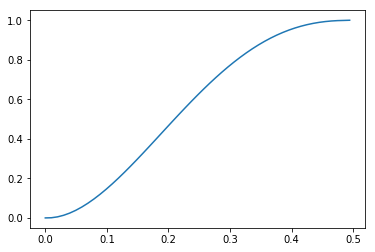

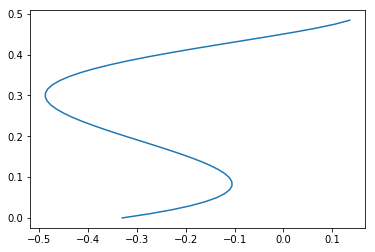

In [117]:
# Plot
# plot_xz(traj)
plt.plot(time_array, traj[:,0])
plt.show()
plot_u(time_array[:-1], input_traj)

In [118]:
# trajectory found
dt = time_array[1] - time_array[0]
for i in range(len(traj)):
    draw_transformation(traj[i,:])
    time.sleep(dt)

In [112]:
angle = 0.0
angle_vel = 0.0 # 5.0
current_state = (1.,0.,0.0,0.0,angle,0.,0.,0.,0.,0.,0.,angle_vel,0.,0.)
draw_transformation(current_state)

In [111]:
# code to simulate passive dynamics
sec = 2.0 # seconds
steps_per_sec = 1000.0 # discrete steps in a second
num_steps = sec*steps_per_sec # total number of steps
sec_per_step = sec/num_steps # number of seconds per step
for t in np.linspace(0,sec,num_steps):
    
    # update state
    # no input
    force = [0.,0.,0.,0.,0.,0.,0.,0.]
    torque = [-0.0]
    current_state = current_state + cube_dynamics(current_state,torque, force)*sec_per_step
#     print(current_state[11])
    # update the state of the cart
    draw_transformation(current_state)
    time.sleep(sec_per_step)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  
